In [ ]:
import pandas as pd
import scipy.stats as stats
import pylab as pl
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from scipy.optimize import curve_fit
from math import sqrt
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.linear_model import Lasso

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


0.04965120953496256 0.26595224441898524


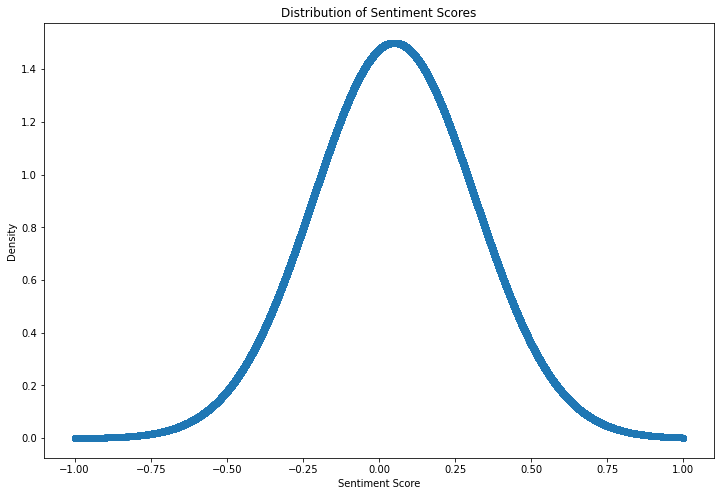

In [ ]:
#STEP 1: Take sample of 250k Tweets for every file, add sentiment scores to a list, find mean and std, check for normal distribution

sentiment = []

def add_sentiment (file):
  #take random sample of 250k tweets in the dataset
  df = pd.read_csv(file)
  df = df.iloc[:,1]
  #display(df.count())
  df = df.sample(n=250000, replace = 'True',random_state=25)

  #add values of sentiment to list
  arr = df.to_numpy()
  for i in arr:
    sentiment.append(i)

#repeat for every file that contains tweets
for i in range(3, 106):
  add_sentiment("/content/drive/My Drive/covid19 tweets/corona_tweets_{}.csv".format(i))

#sort sentiment scores
sentiment.sort()

#find mean and standard deviation to use when normalzing data
mean = np.mean(sentiment)
std = np.std(sentiment)


#normal distribution graph
fit = stats.norm.pdf(sentiment, np.mean(sentiment), np.std(sentiment))
#pl.hist(sentiment,normed=True)
plt.figure(figsize=(12,8))
plt.title("Distribution of Sentiment Scores")
plt.xlabel("Sentiment Score")
plt.ylabel("Density")
pl.plot(sentiment,fit,'-o')
plt.savefig("NormalDistrubition")
pl.show()


In [ ]:
#STEP 2: For each dataset of 250k tweets, normalize data and categorize tweets as -1, 0, 1

pos_scores = []
neg_scores = []
neu_scores = []

def sentiment_score(file,mean,std):
  df = pd.read_csv(file)
  df = df.iloc[:,1]
  df = df.sample(n=250000,replace='True',random_state=25)
  arr = df.to_numpy()
  #arr = arr[arr != 0]

  neu = 0
  neg = 0
  pos = 0

  #categorize data into -1,0,1
  for i in arr:
    if i >= (mean-std) and i <= (mean+std):
      neu += 1
    elif i > mean+std:
      pos += 1
    else:
      neg += 1

  #print (pos,neg,neu)
  #print(df.describe())

  #plt.hist(arr, bins = 20, edgeColor = "black")
  #plt.xlabel("Sentiment Score")
  #plt.show()

  pos_scores.append(pos)
  neg_scores.append(neg)
  neu_scores.append(neu)

for i in range(3, 106):
  sentiment_score("/content/drive/My Drive/covid19 tweets/corona_tweets_{}.csv".format(i),mean,std)


In [ ]:
#Covid-19 datasets for US and Worldwide

covid_cases = []

#global dataset (new covid cases)
#infection_rate = pd.read_csv('datasets_494766_1364666_day_wise.csv')
#infection_rate = infection_rate.drop(infection_rate.index[67])
#infection_rate = infection_rate.loc[58:]

#US dataset (new covid cases)
infection_rate = pd.read_csv('/content/drive/My Drive/covid19 tweets/owid-covid-data (1).csv')
#infection_rate = infection_rate.drop(infection_rate.index[30443])
infection_rate = infection_rate.loc[30434:30559]

new_cases = infection_rate["new_cases"]
new_cases = new_cases.to_numpy()
for i in new_cases:
  covid_cases.append(i)

In [ ]:
#STEP 3: Calculate moving average

neg_scores_avg = []
pos_scores_avg = []
neu_scores_avg = []
covid_cases_avg = []

def moving_average(scores):
  temp = 0 
  scores_avg = []
  for i in range(1,len(scores)+1):
    if i < 4:
      for j in range(i):
        temp += scores[j]
      temp = temp/(i)
      scores_avg.append(temp)
    else:
      for j in range(3):
        temp += scores[i-1-j]
      temp = temp/3
      scores_avg.append(temp)
    temp = 0
  return scores_avg

neg_scores_avg = moving_average(neg_scores)
pos_scores_avg = moving_average(pos_scores)
neu_scores_avg = moving_average(neu_scores)
covid_cases_avg = moving_average(covid_cases)

In [ ]:
#STEP 4: Calculation Pearson coefficient for each dataset with an offset from 0-21 days, add r score to respective list

r_neg = []
r_pos = []
r_neu = []

days = np.arange(22)

#calculate r for each offset in days from 0 to 21 days

#for days before tweet
'''
for i in range(0,21):
  neg_corr, _ = pearsonr(neg_scores_avg, covid_cases_avg[21-i:124-i])
  pos_corr, _ = pearsonr(pos_scores_avg, covid_cases_avg[21-i:124-i])
  neu_corr, _ = pearsonr(neu_scores_avg, covid_cases_avg[21-i:124-i])

  r_neg.append((neg_corr))
  r_pos.append((pos_corr))
  r_neu.append((neu_corr))
'''

#for days after tweet
for i in range(0,22):
  neg_corr, _ = pearsonr(neg_scores_avg, covid_cases_avg[0+i:103+i])
  pos_corr, _ = pearsonr(pos_scores_avg, covid_cases_avg[0+i:103+i])
  neu_corr, _ = pearsonr(neu_scores_avg, covid_cases_avg[0+i:103+i])

  r_neg.append((neg_corr))
  r_pos.append((pos_corr))
  r_neu.append((neu_corr))

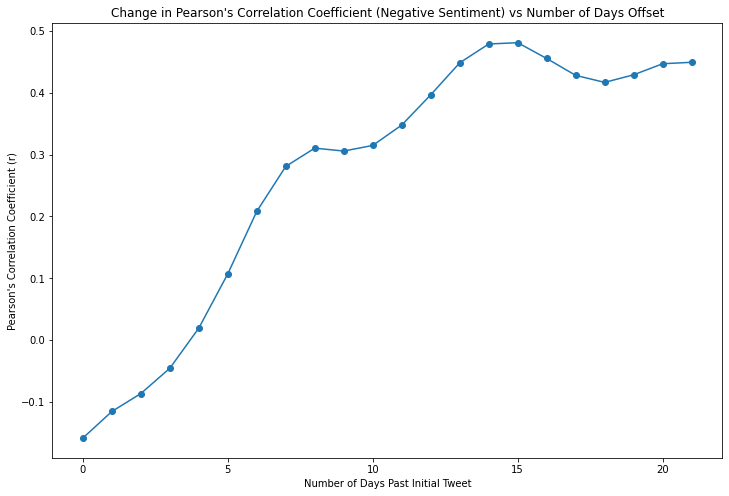

0.48107236378905527


In [ ]:
#STEP 5a: Plot Change in r score over number of days offset for negative

plt.figure(figsize=(12,8))
plt.scatter(days,r_neg)
plt.plot(days,r_neg)
plt.title("Change in Pearson's Correlation Coefficient (Negative Sentiment) vs Number of Days Offset")
plt.ylabel("Pearson's Correlation Coefficient (r)")
plt.xlabel("Number of Days Past Initial Tweet")
plt.savefig("Change in Pearson's Correlation Coefficient (Negative Sentiment) vs Number of Days Offset")
plt.show()

print(max(r_neg))

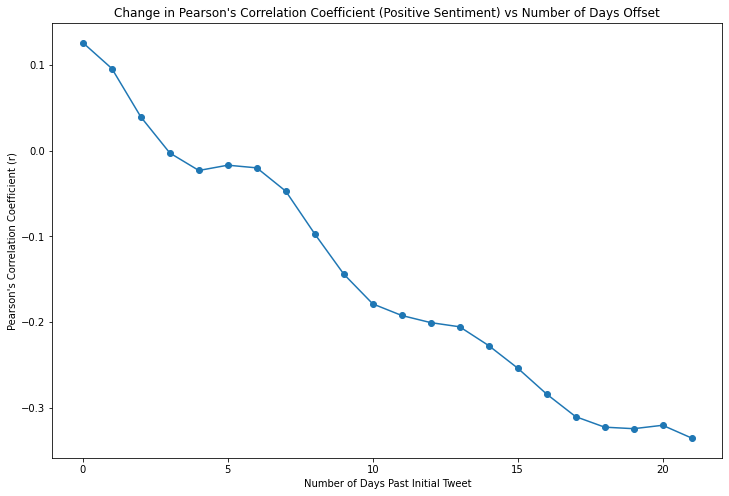

-0.3354583888723664


In [ ]:
#STEP 5b: Plot Change in r score over number of days offset for positive

plt.figure(figsize=(12,8))
plt.scatter(days,r_pos)
plt.plot(days,r_pos)
plt.title("Change in Pearson's Correlation Coefficient (Positive Sentiment) vs Number of Days Offset")
plt.ylabel("Pearson's Correlation Coefficient (r)")
plt.xlabel("Number of Days Past Initial Tweet")
plt.savefig("Change in Pearson's Correlation Coefficient (Positive Sentiment) vs Number of Days Offset")
plt.show()
print(min(r_pos))

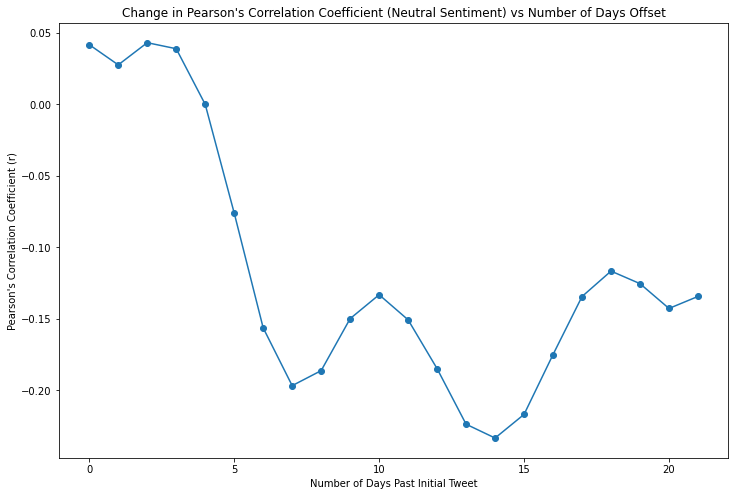

-0.23345326567335045


In [ ]:
#STEP 5c: Plot Change in r score over number of days offset for neutral

plt.figure(figsize=(12,8))
plt.scatter(days,r_neu)
plt.plot(days,r_neu)
plt.title("Change in Pearson's Correlation Coefficient (Neutral Sentiment) vs Number of Days Offset")
plt.ylabel("Pearson's Correlation Coefficient (r)")
plt.xlabel("Number of Days Past Initial Tweet")
plt.savefig("Change in Pearson's Correlation Coefficient (Neutral Sentiment) vs Number of Days Offset")
plt.show()

print(min(r_neu))

In [ ]:
#Functions used later on

def regression(X, y, r_sq, rmse):
  for i in range(1, 51):
    DEGREE = i
    degree.append(i)

    n = X.shape[0]
    trans_X = np.repeat(X, DEGREE).reshape((n, DEGREE))

    for i in range(2, DEGREE+1):
      trans_X[:, i-1] **= i

    model.fit(trans_X, y)
    trans_w = model.coef_
    trans_b = model.intercept_
    #print(trans_w)
    #print(trans_b)

    trans_yhat = model.predict(trans_X)

    rmse.append(sqrt(mean_squared_error(y, trans_yhat)))
    r_sq.append(model.score(trans_X, y))
 
def best_fit(DEGREE, X, y):
  n = X.shape[0]
  trans_X = np.repeat(X, DEGREE).reshape((n, DEGREE))

  for i in range(2, DEGREE+1):
    trans_X[:, i-1] **= i

  model.fit(trans_X, y)
  trans_w = model.coef_
  trans_b = model.intercept_
  #print(trans_w)
  #print(trans_b)

  trans_yhat = model.predict(trans_X)

  print(sqrt(mean_squared_error(y, trans_yhat)))
  print(model.score(trans_X, y))


  plt.figure(figsize=(12,8))
  #plt.plot(X, trans_yhat,color='red')
  plt.scatter(X, trans_yhat,color='red')
  plt.scatter(X, y)

def train_val_test_split(dataset):
  return np.split(dataset, [int(dataset.shape[0] * 0.8)])

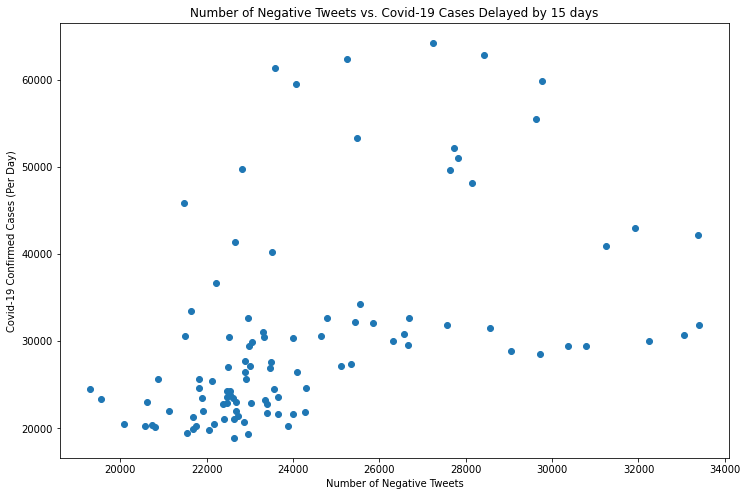

In [ ]:
#STEP 6a: Plot Negative Tweets vs. Covid-19 new cases with delay

DELAY = 15

plt.figure(figsize=(12,8))
plt.scatter(neg_scores_avg, covid_cases_avg[DELAY:103+DELAY])
plt.title("Number of Negative Tweets vs. Covid-19 Cases Delayed by 15 days")
plt.xlabel("Number of Negative Tweets")
plt.ylabel("Covid-19 Confirmed Cases (Per Day)")
plt.savefig("Number of Negative Tweets vs Covid-19 Cases Delayed by 15 days (3-day moving average)")
plt.show()

3353.804526559764
24011.77114746197


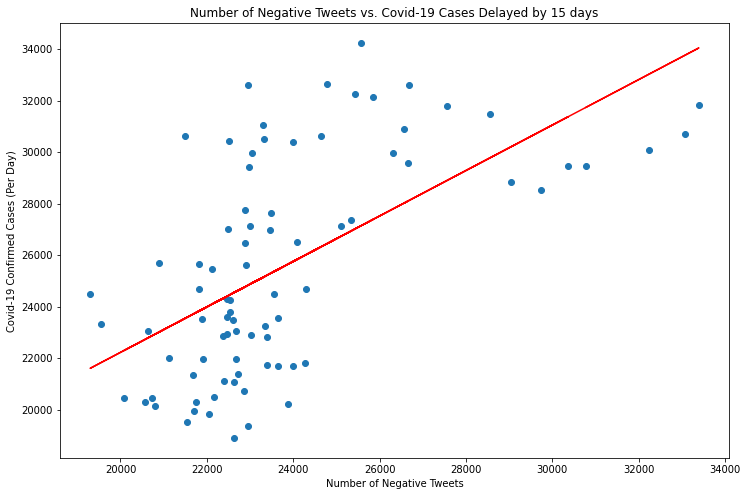

In [ ]:
X = np.array(neg_scores_avg)
X = X.reshape((-1,1))
y = np.array(covid_cases_avg[DELAY:103+DELAY])

#split dataset into train, val, test
X_train, X_test = train_val_test_split(X)
y_train, y_test = train_val_test_split(y)

#fit the train dataset to create weight and bias
model = LinearRegression()
model.fit(X_train, y_train)
w = model.coef_
b = model.intercept_

#print(w)
#print(b)
#print(model.score(X_train, y_train))

#Predict using model and find mse of both train and val
yhat_train = model.predict(X_train)
print(sqrt(mean_squared_error(y_train, yhat_train)))

yhat_test = model.predict(X_test)
print(sqrt(mean_squared_error(y_test, yhat_test)))

#plot data with linear regression line
plt.figure(figsize=(12,8))
plt.plot(X_train,yhat_train,color='red')
plt.scatter(X_train,y_train)
plt.title("Number of Negative Tweets vs. Covid-19 Cases Delayed by 15 days")
plt.xlabel("Number of Negative Tweets")
plt.ylabel("Covid-19 Confirmed Cases (Per Day)")
plt.savefig("Number of Negative Tweets vs Covid-19 Cases Delayed by 15 days - Linear Regression")
plt.show()

0.42325498613548823
3190.145907173487
23342.728369631455


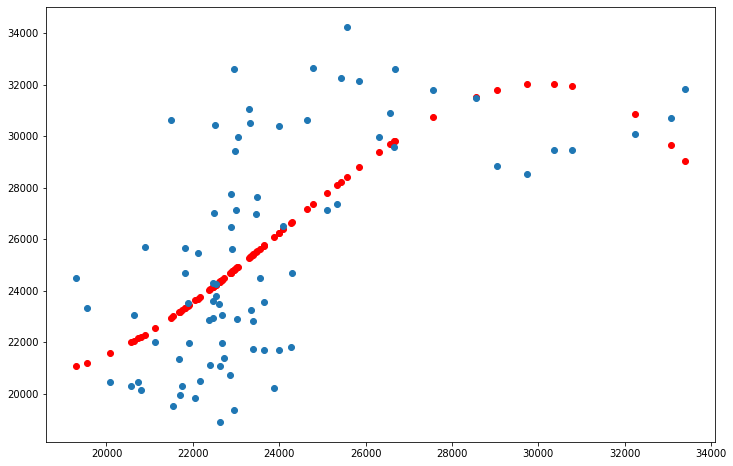

In [ ]:
DEGREE = 3

n = X.shape[0]
trans_X = np.repeat(X, DEGREE).reshape((n, DEGREE))

for i in range(2, DEGREE+1):
  trans_X[:, i-1] **= i

trans_X_train, trans_X_test = train_val_test_split(trans_X)
trans_y_train, trans_y_test = train_val_test_split(y)

model.fit(trans_X_train, trans_y_train)
trans_w = model.coef_
trans_b = model.intercept_
#print(trans_w)
#print(trans_b)
print(model.score(trans_X_train, trans_y_train))

trans_yhat_train = model.predict(trans_X_train)
trans_yhat_test = model.predict(trans_X_test)

print(sqrt(mean_squared_error(trans_yhat_train, trans_y_train)))
print(sqrt(mean_squared_error(trans_yhat_test, trans_y_test)))

plt.figure(figsize=(12,8))
plt.scatter(X_train, trans_yhat_train,color='red')
plt.scatter(X_train , y_train)

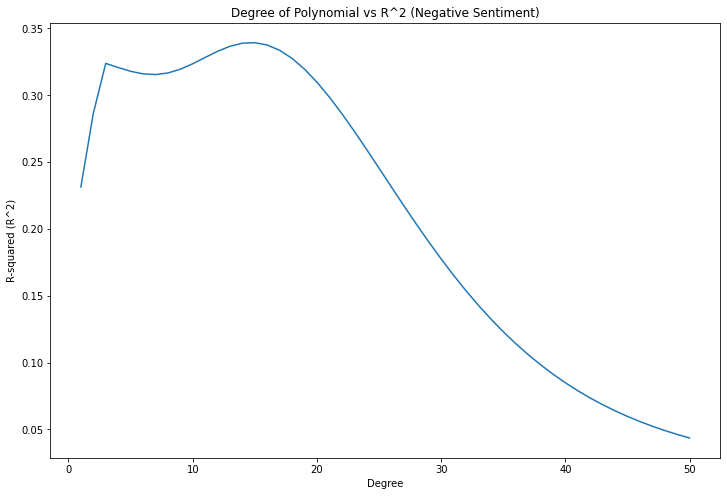

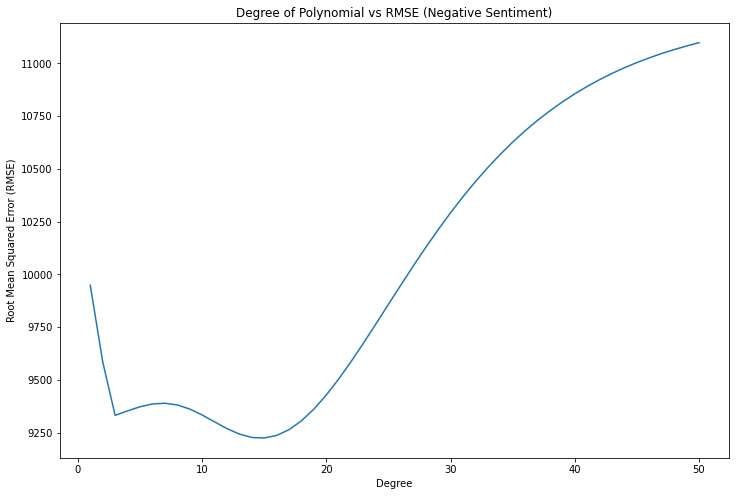

In [ ]:
#STEP 7a: Find optimal degree for best fit model (RMSE / R^2)
DELAY = 15

X = np.array(neg_scores_avg)
X = X.reshape((-1,1))
y = np.array(covid_cases_avg[DELAY:103+DELAY])

neg_r_sq = []
neg_rmse = []
degree = []

regression(X, y, neg_r_sq, neg_rmse)
plt.figure(figsize=(12,8))
plt.plot(degree, neg_r_sq)
plt.xlabel("Degree")
plt.ylabel("R-squared (R^2)")
plt.title("Degree of Polynomial vs R^2 (Negative Sentiment)")
plt.savefig("Degree of Polynomial vs R^2 (Negative Sentiment)")

plt.figure(figsize=(12,8))
plt.plot(degree, neg_rmse)
plt.xlabel("Degree")
plt.ylabel("Root Mean Squared Error (RMSE)")
plt.title("Degree of Polynomial vs RMSE (Negative Sentiment)")
plt.savefig("Degree of Polynomial vs RMSE (Negative Sentiment)")

[-8.15486276e+01  3.44244746e-03 -4.65433519e-08]
648557.3401313879
9331.503085262317
0.32381417738456425


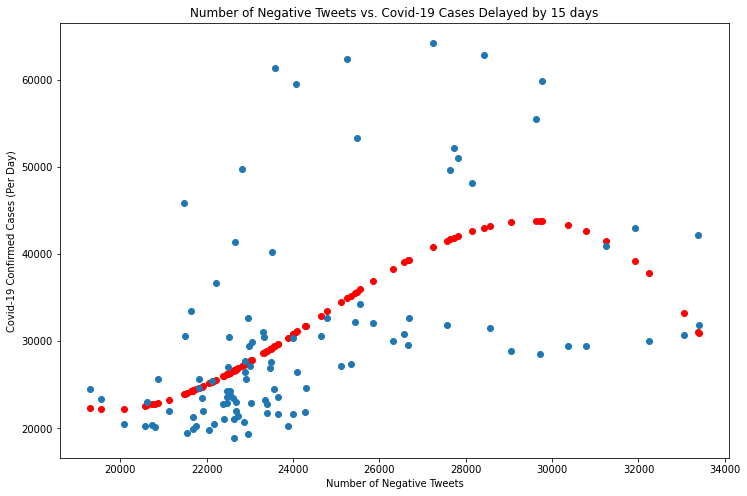

In [ ]:
#STEP 8a: Regression
DEGREE = 3
DELAY = 15

X = np.array(neg_scores_avg)
X = X.reshape((-1,1))
y = np.array(covid_cases_avg[DELAY:103+DELAY])

n = X.shape[0]
trans_X = np.repeat(X,DEGREE).reshape((n, DEGREE))

for i in range(2, DEGREE + 1):
  trans_X[:,i-1] **=i

model = LinearRegression()
model.fit(trans_X, y) 
trans_w = model.coef_
trans_b = model.intercept_
print(trans_w)
print(trans_b)

trans_yhat = model.predict(trans_X)

print(sqrt(mean_squared_error(y, trans_yhat)))
print(model.score(trans_X, y))

plt.figure(figsize=(12,8))
plt.scatter(X, trans_yhat, color='red')
plt.scatter(X, y)
plt.title("Number of Negative Tweets vs. Covid-19 Cases Delayed by 15 days")
plt.xlabel("Number of Negative Tweets")
plt.ylabel("Covid-19 Confirmed Cases (Per Day)")
plt.savefig("Number of Negative Tweets vs Covid-19 Cases Delayed by 15 days - 3rd Degree Model")
plt.show()

$\hat{Y} = -8.15*10^1X_1 + 3.44*10^-3X_1^2 - 4.65*10^-8X_1^3 + 648557.34$

In [ ]:
#LASSO REGRESSION

m = np.mean(trans_X,axis=0)
s = np.std(trans_X,axis=0)

trans_standard_X = trans_X.copy()
trans_standard_X -= m
trans_standard_X /= s

lasso = Lasso(alpha=1.0)
lasso.fit(trans_standard_X,y)
w = lasso.coef_
b = lasso.intercept_
print(w)
print(b)

yhat = lasso.predict(trans_standard_X)
print(sqrt(mean_squared_error(y, yhat)))

[10617.15442054 -5978.45239192 -7205.88675396]
30241.822006472652
10620.28896471807


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4702240754.218793, tolerance: 1232171.3103736786
  positive)


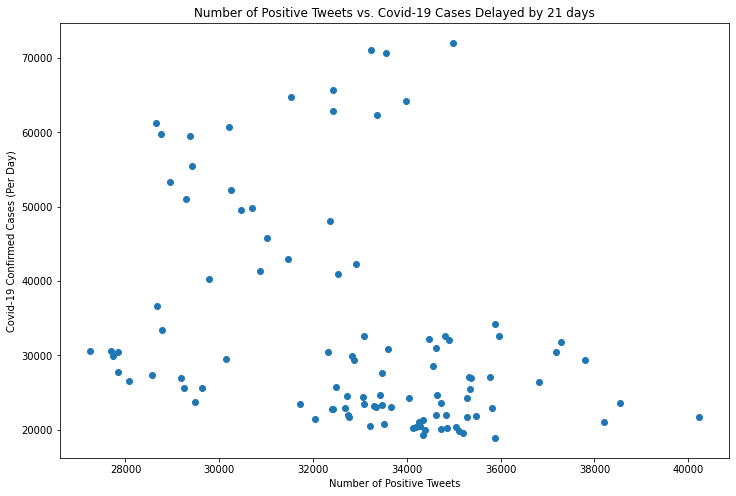

In [ ]:
#STEP 6b: Plot Positive Tweets vs. Covid-19 new cases with delay
DELAY = 21

plt.figure(figsize=(12,8))
plt.scatter(pos_scores_avg, covid_cases_avg[DELAY:103+DELAY])
plt.title("Number of Positive Tweets vs. Covid-19 Cases Delayed by 21 days")
plt.xlabel("Number of Positive Tweets")
plt.ylabel("Covid-19 Confirmed Cases (Per Day)")
plt.savefig("Number of Positive Tweets vs Covid-19 Cases Delayed by 21 days (7-day moving average)")
plt.show()

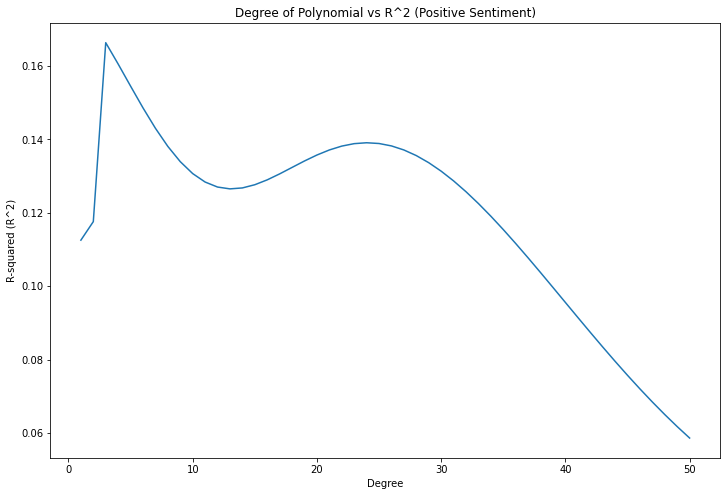

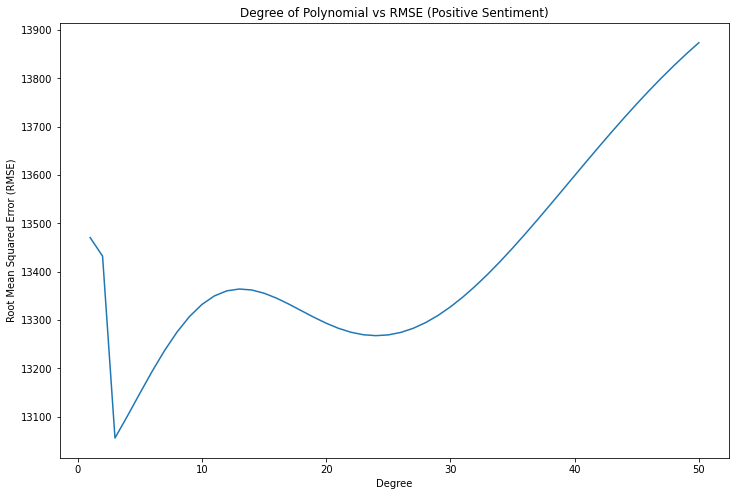

In [ ]:
#STEP 7b: Find optimal degree for best fit model (RMSE / R^2)
DELAY = 21

X = np.array(pos_scores_avg)
X = X.reshape((-1,1))
y = np.array(covid_cases_avg[DELAY:103+DELAY])

pos_r_sq = []
pos_rmse = []
degree = []

regression(X, y, pos_r_sq, pos_rmse)
plt.figure(figsize=(12,8))
plt.plot(degree, pos_r_sq)
plt.xlabel("Degree")
plt.ylabel("R-squared (R^2)")
plt.title("Degree of Polynomial vs R^2 (Positive Sentiment)")
plt.savefig("Degree of Polynomial vs R^2 (Positive Sentiment)")

plt.figure(figsize=(12,8))
plt.plot(degree, pos_rmse)
plt.xlabel("Degree")
plt.ylabel("Root Mean Squared Error (RMSE)")
plt.title("Degree of Polynomial vs RMSE (Positive Sentiment)")
plt.savefig("Degree of Polynomial vs RMSE (Positive Sentiment)")


[ 3.32355010e+02 -9.96099774e-03  9.83266370e-08]
-3619132.9554373883
13055.951298771042
0.1663385438214856


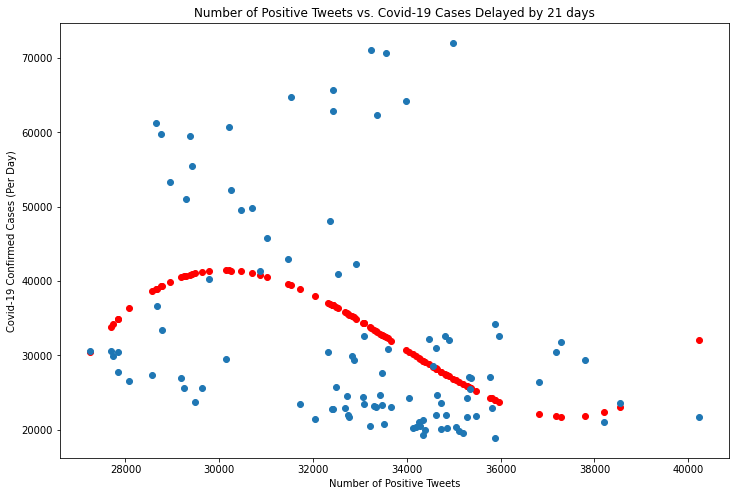

In [ ]:
#STEP 8b: Regression
DEGREE = 3
DELAY = 21

X = np.array(pos_scores_avg)
X = X.reshape((-1,1))
y = np.array(covid_cases_avg[DELAY:103+DELAY])

n = X.shape[0]
trans_X = np.repeat(X, DEGREE).reshape((n, DEGREE))

for i in range(2, DEGREE+1):
  trans_X[:, i-1] **= i

model.fit(trans_X, y)
trans_w = model.coef_
trans_b = model.intercept_
print(trans_w)
print(trans_b)

trans_yhat = model.predict(trans_X)

print(sqrt(mean_squared_error(y, trans_yhat)))
print(model.score(trans_X, y))


plt.figure(figsize=(12,8))
#plt.plot(X, trans_yhat,color='red')
plt.title('Number of Positive Tweets vs. Covid-19 Cases Delayed by 21 days')
plt.xlabel('Number of Positive Tweets')
plt.ylabel('Covid-19 Confirmed Cases (Per Day)')
plt.scatter(X, trans_yhat,color='red')
plt.scatter(X, y)
plt.savefig("Number of Positive Tweets vs Covid-19 Cases Delayed by 21 days - 3rd Degree Model")
plt.show()

$\hat{Y} = 3.32*10^2X_1 - 9.96*10^-3X_1^2 - 9.83*10^-8X_1^3 - 3619132.96$

In [ ]:
#LASSO REGRESSION

m = np.mean(trans_X,axis=0)
s = np.std(trans_X,axis=0)

trans_standard_X = trans_X.copy()
trans_standard_X -= m
trans_standard_X /= s

lasso = Lasso(alpha=1.0)
lasso.fit(trans_standard_X,y)
w = lasso.coef_
b = lasso.intercept_
print(w)
print(b)

yhat = lasso.predict(trans_standard_X)
print(sqrt(mean_squared_error(y, yhat)))

[  9142.36054608 -11684.25877814  -2288.34358443]
32736.559870550183
13435.200711682251


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5402573467.418246, tolerance: 2106029.9590936354
  positive)


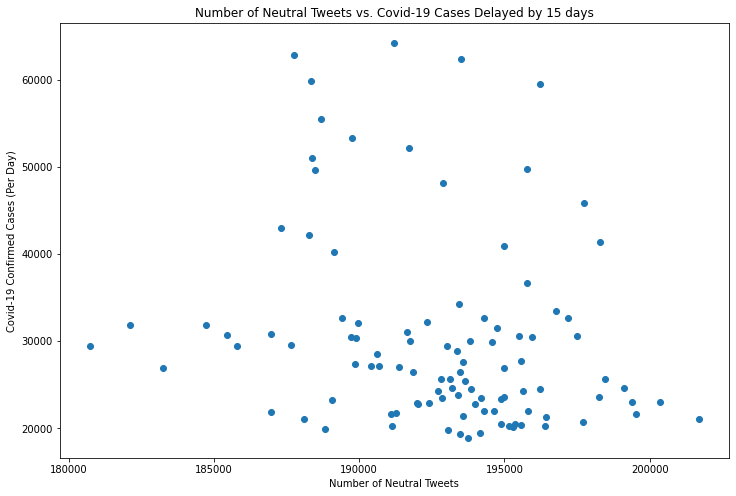

In [ ]:
#STEP 6c: Plot Neutral Tweets vs. Covid-19 new cases with delay

DELAY = 14

plt.figure(figsize=(12,8))
plt.scatter(neu_scores_avg, covid_cases_avg[DELAY:103+DELAY])
plt.title("Number of Neutral Tweets vs. Covid-19 Cases Delayed by 15 days")
plt.xlabel("Number of Neutral Tweets")
plt.ylabel("Covid-19 Confirmed Cases (Per Day)")
plt.savefig("Number of Neutral Tweets vs Covid-19 Cases Delayed by 15 days (7-day moving average)")
plt.show()

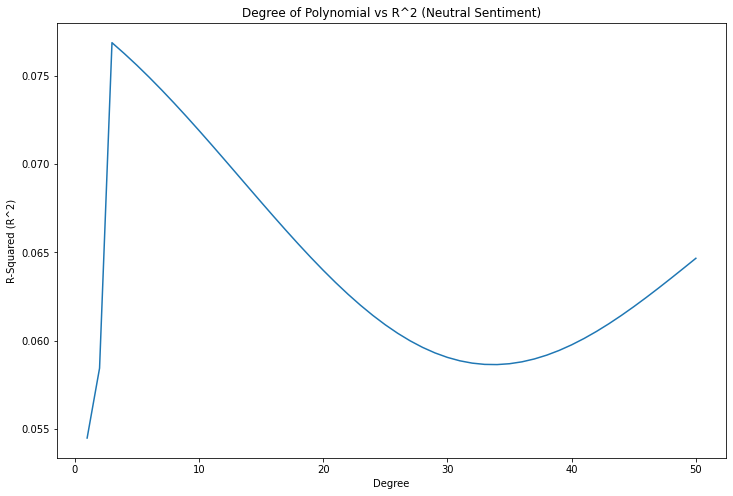

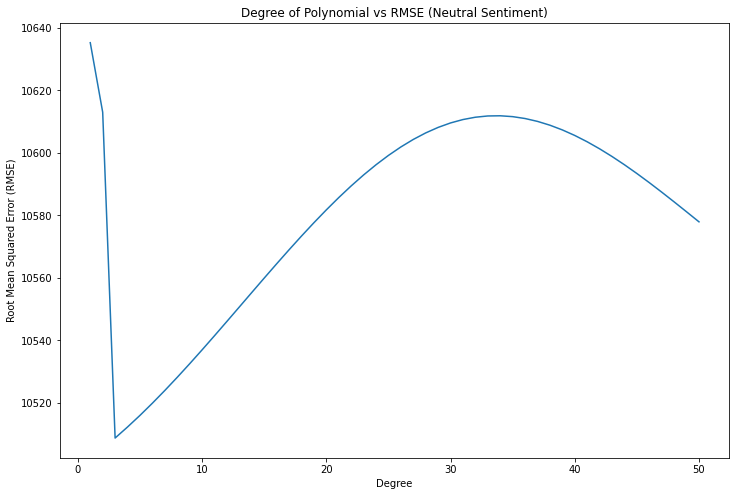

In [ ]:
#STEP 7c: Find optimal degree for best fit model (RMSE / R^2)

DELAY = 14

X = np.array(neu_scores_avg)
X = X.reshape((-1,1))
y = np.array(covid_cases_avg[DELAY:103+DELAY])

neu_r_sq = []
neu_rmse = []
degree = []

regression(X, y, neu_r_sq, neu_rmse)
plt.figure(figsize=(12,8))
plt.plot(degree, neu_r_sq)
plt.xlabel("Degree")
plt.ylabel("R-Squared (R^2)")
plt.title("Degree of Polynomial vs R^2 (Neutral Sentiment)")
plt.savefig("Degree of Polynomial vs R^2 (Neutral Sentiment)")

plt.figure(figsize=(12,8))
plt.plot(degree, neu_rmse)
plt.xlabel("Degree")
plt.ylabel("Root Mean Squared Error (RMSE)")
plt.title("Degree of Polynomial vs RMSE (Neutral Sentiment)")
plt.savefig("Degree of Polynomial vs RMSE (Neutral Sentiment)")


[ 1.22271542e+03 -6.36398259e-03  1.10302181e-08]
-78198896.51506999
10508.713396191451
0.07686497808411996


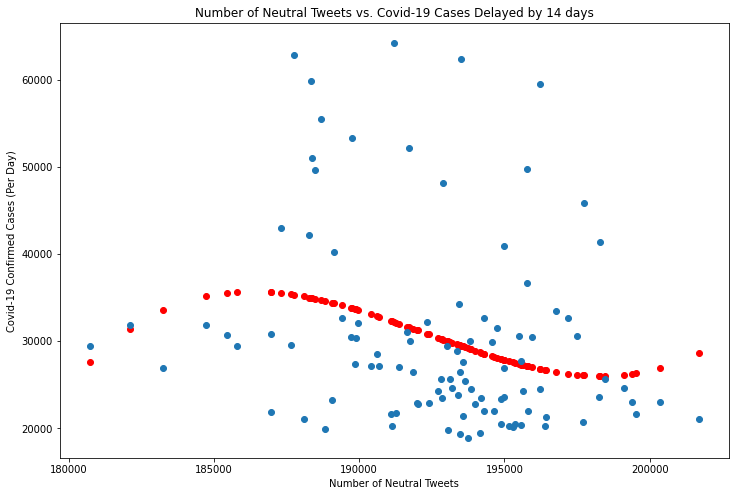

In [ ]:
#STEP 8c: Regression
DEGREE = 3
DELAY = 14

X = np.array(neu_scores_avg)
X = X.reshape((-1,1))
y = np.array(covid_cases_avg[DELAY:103+DELAY])

n = X.shape[0]
trans_X = np.repeat(X, DEGREE).reshape((n, DEGREE))

for i in range(2, DEGREE+1):
  trans_X[:, i-1] **= i

model.fit(trans_X, y)
trans_w = model.coef_
trans_b = model.intercept_
print(trans_w)
print(trans_b)

trans_yhat = model.predict(trans_X)

print(sqrt(mean_squared_error(y, trans_yhat)))
print(model.score(trans_X, y))


plt.figure(figsize=(12,8))
#plt.plot(X, trans_yhat,color='red')
plt.title('Number of Neutral Tweets vs. Covid-19 Cases Delayed by 14 days')
plt.xlabel('Number of Neutral Tweets')
plt.ylabel('Covid-19 Confirmed Cases (Per Day)')
plt.scatter(X, trans_yhat,color='red')
plt.scatter(X, y)
plt.savefig("Number of Neutral Tweets vs Covid-19 Cases Delayed by 14 days - 3rd Degree Model")
plt.show()

$\hat{Y} = 1.22*10^3X_1 - 6.36*10^-3X_1^2 + 1.10*10^-8X_1^3 - 78198896.52$

In [ ]:
#LASSO REGRESSION

m = np.mean(trans_X,axis=0)
s = np.std(trans_X,axis=0)

trans_standard_X = trans_X.copy()
trans_standard_X -= m
trans_standard_X /= s

lasso = Lasso(alpha=1.0)
lasso.fit(trans_standard_X,y)
w = lasso.coef_
b = lasso.intercept_
print(w)
print(b)

yhat = lasso.predict(trans_standard_X)
print(sqrt(mean_squared_error(y, yhat)))

[10617.15442054 -5978.45239192 -7205.88675396]
30241.822006472652
10620.28896471807


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4702240754.218793, tolerance: 1232171.3103736786
  positive)


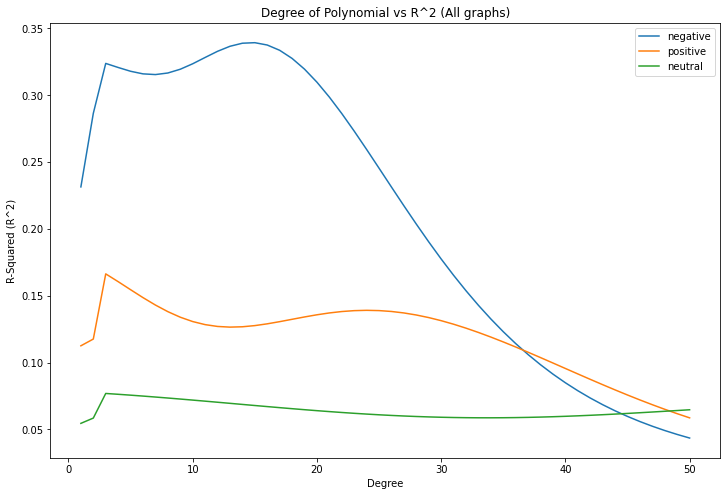

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(degree, neg_r_sq, label="negative")
plt.plot(degree, pos_r_sq, label="positive")
plt.plot(degree, neu_r_sq, label="neutral")
plt.legend()
plt.xlabel("Degree")
plt.ylabel("R-Squared (R^2)")
plt.title("Degree of Polynomial vs R^2 (All graphs)")
plt.savefig("Degree of Polynomial vs R^2")
plt.show()

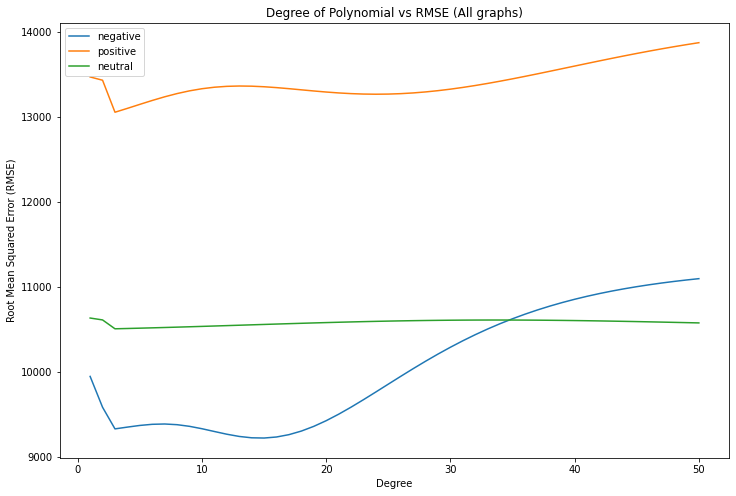

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(degree, neg_rmse, label="negative")
plt.plot(degree, pos_rmse, label="positive")
plt.plot(degree, neu_rmse, label="neutral")
plt.legend()
plt.xlabel("Degree")
plt.ylabel("Root Mean Squared Error (RMSE)")
plt.title("Degree of Polynomial vs RMSE (All graphs)")
plt.savefig("Degree of Polynomial vs RMSE")
plt.show()